In [1]:
# !pip install open_clip_torch rdflib pandas matplotlib scikit-learn tqdm
import os
import pandas as pd
import numpy as np
import torch
import pickle
import open_clip
from PIL import Image
from tqdm.auto import tqdm
from rdflib import Graph, Literal, RDF, Namespace, URIRef
from rdflib.namespace import OWL, RDFS, SKOS

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import cv2
from torch.utils.data import Dataset, DataLoader
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import gc

# Graphical
%matplotlib inline
print("Libraries imported successfully!")

c:\Users\ASUS\.conda\envs\clean_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully!


In [2]:
# Path settings
dataset_root = os.path.join("..", "dataset", "images")
images_folder = os.path.join(dataset_root, "images_normalized")
projections_path = os.path.join(dataset_root, "indiana_projections.csv")
reports_path = os.path.join(dataset_root, "indiana_reports.csv")

In [3]:
#read and merge data
df_proj = pd.read_csv(projections_path)
df_rep = pd.read_csv(reports_path)
df_merged = pd.merge(df_proj, df_rep, on='uid', how='inner')

In [4]:
#construct image path and caption
def get_valid_path(filename):
    path = os.path.join(images_folder, str(filename))
    return path if os.path.exists(path) else None

In [5]:
df_merged['image_path'] = df_merged['filename'].apply(get_valid_path)
df_merged['caption'] = (df_merged['findings'].fillna('') + " " + df_merged['impression'].fillna('')).str.strip()

In [6]:
#final filter
df_final = df_merged.dropna(subset=['image_path'])
df_final = df_final[df_final['caption'].str.len() > 5]

print(f"Total images: {len(df_final)}")

Total images: 7426


In [7]:
# Cell: Load BiomedCLIP model (run ONCE)


MODEL_NAME = 'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Loading BiomedCLIP model: {MODEL_NAME} on {device}...")
model, _, preprocess = open_clip.create_model_and_transforms(MODEL_NAME)
model.to(device)
model.eval()
print("BiomedCLIP model loaded and ready.")

Loading BiomedCLIP model: hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224 on cuda...


c:\Users\ASUS\.conda\envs\clean_env\lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


BiomedCLIP model loaded and ready.


In [8]:
# Cell: DATASET REPAIR & EMBEDDING GENERATION

# ---------------------------------------------------------
# Step 1: Find all actual image files on disk
# ---------------------------------------------------------
base_path = os.path.abspath(os.path.join("..", "dataset", "images", "images_normalized"))
print(f"Scanning folder: {base_path}")

if not os.path.exists(base_path):
    raise FileNotFoundError("Critical: Image folder path is wrong!")

files_on_disk = set(os.listdir(base_path))
print(f"Found {len(files_on_disk)} files on disk.")

# ---------------------------------------------------------
# Step 2: Clean the DataFrame to keep only valid image files
# ---------------------------------------------------------
print("Cleaning DataFrame to match existing files...")

def get_real_filepath(filename):
    fname = str(filename).strip()
    
    if fname in files_on_disk:
        return os.path.join(base_path, fname)
    
    if fname + ".png" in files_on_disk:
        return os.path.join(base_path, fname + ".png")
        
    if fname + ".jpg" in files_on_disk:
        return os.path.join(base_path, fname + ".jpg")
    
    return None 

df_final['real_path'] = df_final['filename'].apply(get_real_filepath)
df_clean = df_final.dropna(subset=['real_path']).copy()

print(f"Rows before cleaning: {len(df_final)}")
print(f"Rows after cleaning (Valid Images): {len(df_clean)}")

if len(df_clean) == 0:
    print("CRITICAL: No match found between CSV filenames and Disk filenames!")
    print("Example CSV filename:", df_final['filename'].iloc[0])
    print("Example Disk filename:", list(files_on_disk)[0])
    raise ValueError("Dataset Mismatch! Please check your CSV vs Image folder.")

# ---------------------------------------------------------
# Step 3: Generate unique image embeddings using BiomedCLIP
# ---------------------------------------------------------
print("Generating UNIQUE embeddings...")

device = "cuda" if torch.cuda.is_available() else "cpu"



def generate_embedding(path):
    try:
        image = Image.open(path).convert("RGB")
        image_input = preprocess(image).unsqueeze(0).to(device)
        with torch.no_grad():
            emb = model.encode_image(image_input)
            emb /= emb.norm(dim=-1, keepdim=True)
        return emb.cpu().numpy().flatten()
    except:
        return None

tqdm.pandas()
df_clean['embedding'] = df_clean['real_path'].progress_apply(generate_embedding)


df_clean = df_clean.dropna(subset=['embedding'])

# ---------------------------------------------------------
# Step 4: Quick sanity check to verify embedding diversity
# ---------------------------------------------------------
if len(df_clean) > 1:
    emb1 = df_clean['embedding'].iloc[0]
    emb2 = df_clean['embedding'].iloc[1]
    
    if np.array_equal(emb1, emb2):
        print("WARNING: Embeddings are STILL identical. Check your images!")
    else:
        print("SUCCESS! Embeddings are diverse and valid.")


# Save the cleaned dataset with embeddings to a pickle file
df_final = df_clean
with open("dataset_final_fixed.pkl", "wb") as f:
    pickle.dump(df_final, f)
print("Saved fixed dataset to dataset_final_fixed.pkl")
print(f"Current Data Shape: {df_final.shape}")

Scanning folder: c:\Users\ASUS\Documents\Programming\uni\AI\dataset\images\images_normalized
Found 7470 files on disk.
Cleaning DataFrame to match existing files...
Rows before cleaning: 7426
Rows after cleaning (Valid Images): 7426
Generating UNIQUE embeddings...


100%|██████████| 7426/7426 [10:13<00:00, 12.10it/s]

SUCCESS! Embeddings are diverse and valid.
Saved fixed dataset to dataset_final_fixed.pkl
Current Data Shape: (7426, 14)


In [9]:
import re


# 1. دیکشنری نگاشت مفاهیم (Ontology Mapping)
ENTITY_MAP = {
    # قلب
    # Heart-related concepts
    "cardiomegaly": "Cardiomegaly", 
    "enlarged heart": "Cardiomegaly", 
    "heart enlargement": "Cardiomegaly", 
    "cardiac enlargement": "Cardiomegaly", 
    "prominent cardiac silhouette": "Cardiomegaly", 
    "ctr > 0.5": "Cardiomegaly",
    
    # ذات‌الریه و عفونت
    # Pneumonia and infectious patterns
    "pneumonia": "Pneumonia", 
    "infection": "Pneumonia", 
    "consolidation": "Pneumonia", 
    "airspace disease": "Pneumonia", 
    "infiltration": "Pneumonia", 
    "opacities": "Pneumonia", 
    "hazy opacity": "Pneumonia",
    
    # آتلتکتازی
    # Atelectasis-related patterns
    "atelectasis": "Atelectasis", 
    "collapse": "Atelectasis", 
    "volume loss": "Atelectasis", 
    "plate-like opacity": "Atelectasis",
    
    # ادم ریوی
    # Pulmonary edema and congestion
    "edema": "Edema", 
    "fluid overload": "Edema", 
    "congestion": "Edema", 
    "pulmonary edema": "Edema", 
    "vascular congestion": "Edema", 
    "kerley b lines": "Edema", 
    "peribronchial cuffing": "Edema",
    
    # پلورال افیوژن
    # Pleural effusion
    "pleural effusion": "PleuralEffusion", 
    "effusion": "PleuralEffusion", 
    "fluid in chest": "PleuralEffusion", 
    "blunting of costophrenic": "PleuralEffusion", 
    "meniscus sign": "PleuralEffusion",
    
    # پنوموتوراکس
    # Pneumothorax
    "pneumothorax": "Pneumothorax", 
    "air in chest": "Pneumothorax", 
    "pleural line": "Pneumothorax", 
    "lucency": "Pneumothorax",
    
    # شکستگی
    # Fracture-related findings
    "fracture": "Fracture", 
    "broken": "Fracture", 
    "deformity": "Fracture", 
    "osseous discontinuity": "Fracture", 
    "callus": "Fracture", 
    "rib fracture": "Fracture",
    
    # نرمال
    # Normal / no acute disease
    "normal": "Normal", 
    "no acute": "Normal", 
    "clear": "Normal", 
    "unremarkable": "Normal", 
    "intact": "Normal", 
    "stable": "Normal", 
    "within normal limits": "Normal", 
    "grossly normal": "Normal"
}

# 2. Text cleaning function
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    # Remove de-identification tags
    text = re.sub(r'xxxx', ' ', text)
    # Keep only letters, digits, spaces and periods
    text = re.sub(r'[^a-z0-9\s\.]', ' ', text)
    # Collapse multiple spaces into a single space
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# 3. Simple negation pattern templates
NEGATION_PATTERNS = [
    r"no evidence of {}",
    r"no definite {}",
    r"no acute {}",
    r"no {}",
    r"without {}",
    r"free of {}",
    r"absence of {}"
]

def is_negated(text, keyword, window=6):
    """
    Check if `keyword` appears in a negated context within a limited word window.
    """
    words = text.split()
    for i, w in enumerate(words):
        if w == "no" or w == "without" or w == "absence":
            for j in range(i+1, min(i+1+window, len(words))):
                if keyword in " ".join(words[j:j+1+window]):
                    return True
    return False


# 4. Heuristic medical entity extraction function
def extract_medical_entities(text):
    if not isinstance(text, str):
        return ["Normal"]

    text = text.lower()
    found_entities = set()

    # For each keyword we search using regex with word boundaries
    for keyword, concept in ENTITY_MAP.items():
        # If the keyword does not appear in the text at all, skip it
        if not re.search(rf"\b{re.escape(keyword)}\b", text):
            continue

        # If this concept is a disease (not 'Normal') and appears in a negated pattern, skip it
        if concept != "Normal" and is_negated(text, keyword):
            continue

        found_entities.add(concept)

    # If both a disease and 'Normal' are present, drop 'Normal' from the set
    if len(found_entities) > 1 and "Normal" in found_entities:
        found_entities.discard("Normal")

    # If nothing is found, default label is 'Normal'
    if not found_entities:
        found_entities.add("Normal")

    return list(found_entities)

print("Cleaning text and extracting entities (with regex + simple negation handling)...")

if 'caption' in df_final.columns:
    df_final['caption'] = df_final['caption'].apply(clean_text)
    df_final['detected_entities'] = df_final['caption'].apply(extract_medical_entities)

    print("Data Preprocessing Done!")
    print(df_final[['caption', 'detected_entities']].head())
else:
    print("Error: 'caption' column not found in df_final. Please check previous cells.")

Cleaning text and extracting entities (with regex + simple negation handling)...
Data Preprocessing Done!
                                             caption detected_entities
0  the cardiac silhouette and mediastinum size ar...          [Normal]
1  the cardiac silhouette and mediastinum size ar...          [Normal]
2  borderline cardiomegaly. midline sternotomy . ...    [Cardiomegaly]
3  borderline cardiomegaly. midline sternotomy . ...    [Cardiomegaly]
4  no displaced rib fractures pneumothorax or ple...          [Normal]


In [10]:
# Cell: Helper Dataset class + batch embedding generation (optional)


# Image enhancement function
def enhance_image(image_path):
    """Improve X-ray contrast with CLAHE and convert to RGB"""
    try:
        # Read file from disk (Windows-safe path handling)
        with open(image_path, "rb") as stream:
            bytes_data = bytearray(stream.read())
        numpyarray = np.asarray(bytes_data, dtype=np.uint8)
        img = cv2.imdecode(numpyarray, cv2.IMREAD_GRAYSCALE)

        if img is None:
            return None

        # Apply CLAHE to enhance local contrast
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced_img = clahe.apply(img)

        # Convert single-channel image to RGB
        img_rgb = cv2.cvtColor(enhanced_img, cv2.COLOR_GRAY2RGB)
        return Image.fromarray(img_rgb)
    except Exception:
        return None

class XRayDataset(Dataset):
    def __init__(self, image_paths, preprocess):
        self.image_paths = image_paths
        self.preprocess = preprocess

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        pil_image = enhance_image(image_path)
        if pil_image is None:
            # If the image cannot be read, return a zero tensor placeholder
            return torch.zeros(3, 224, 224), image_path
        return self.preprocess(pil_image), image_path

In [11]:
def generate_embeddings_batch(df, model, preprocess, device, batch_size=16):
    """
    Take a DataFrame, use a DataLoader to batch the images,
    compute embeddings, and attach them to the DataFrame.
    """

    # 1. Build the list of image paths
    # Ensure indices are aligned so that ordering is preserved
    image_paths = df['image_path'].tolist()

    # 2. Create the Dataset and DataLoader
    # num_workers > 0 would allow parallel image loading alongside GPU computation (higher throughput)
    dataset = XRayDataset(image_paths, preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

    all_embeddings = []

    print(f"Starting embedding generation for {len(df)} images on {device}...")

    # 3. Main loop for embedding generation
    with torch.no_grad():  # Disable gradients to save memory and speed up inference
        for batch_images, batch_paths in tqdm(dataloader, total=len(dataloader)):
            batch_images = batch_images.to(device)

            # Compute image features using the BiomedCLIP model
            image_features = model.encode_image(batch_images)

            # Normalize feature vectors (crucial for later cosine similarity computations)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            # Move tensors back to CPU and convert to NumPy for storage in RAM
            all_embeddings.append(image_features.cpu().numpy())

    # 4. Concatenate all batches into a single array
    final_embeddings = np.concatenate(all_embeddings, axis=0)

    # 5. Attach embeddings back to the DataFrame
    # Because shuffle=False, row order still matches the image order
    df['embedding'] = list(final_embeddings)

    return df

In [12]:
# Cell: Save the FIXED data for future use
import pickle

print("Saving the healthy, fixed dataset...")

# Overwrite the previous file with the current cleaned dataset
with open("dataset_with_embeddings.pkl", "wb") as f:
    pickle.dump(df_final, f)

print(f"Current Data Shape: {df_final.shape}")

Saving the healthy, fixed dataset...
Current Data Shape: (7426, 15)


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import gc

# Memory Cleanup
print("Cleaning up memory...")
if 'model' in globals(): del model
gc.collect()

# 1. Prepare the full dataset
df_all = df_final.copy()

TARGET_DISEASES = ['Cardiomegaly', 'Pneumonia', 'Atelectasis', 'Edema', 
                   'PleuralEffusion', 'Fracture', 'Pneumothorax', 'Normal']

def clean_labels(labels):
    valid = [l for l in labels if l in TARGET_DISEASES]
    if not valid:
        return ["Normal"]
    if "Normal" in valid and len(valid) > 1:
        valid.remove("Normal")
    return valid

print("Processing labels and enforcing consistency...")
y_raw = df_all['detected_entities'].apply(clean_labels).tolist()

# Fit MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=TARGET_DISEASES)
y_all = mlb.fit_transform(y_raw)

# X contains all image embeddings
X_all = np.stack(df_all['embedding'].values)

# ---------------------------------------------------------
# 2. Build Train / Validation / Test split (Strict No-Leakage)
# ---------------------------------------------------------
indices = np.arange(len(df_all))

# First Split: 80% Train+Val, 20% Test
trainval_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)

# Second Split: From that 80%, take 20% for Validation
# (This results in approx: 64% Train, 16% Val, 20% Test)
train_idx, val_idx = train_test_split(trainval_idx, test_size=0.2, random_state=42)

# Create the arrays
X_train = X_all[train_idx]
y_train = y_all[train_idx]

X_val   = X_all[val_idx]
y_val   = y_all[val_idx]

X_test  = X_all[test_idx]
y_test  = y_all[test_idx]

print(f"Split Sizes -> Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
# --- Compatibility aliases for old cells ---
train_indices = train_idx
val_indices   = val_idx
test_indices  = test_idx

# اگر جایی استفاده می‌کنی:
all_embeddings_raw = X_all


Cleaning up memory...
Processing labels and enforcing consistency...
Split Sizes -> Train: 4752, Val: 1188, Test: 1486


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pickle

print("Starting Calibrated Training Pipeline...")

# 1) Create an internal split within TRAIN for calibration
# X_fit: to train the Random Forest
# X_cal: to train the Sigmoid Calibrator (Platt Scaling)
X_fit_raw, X_cal_raw, y_fit, y_cal = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# 2) Fit Scaler ONLY on X_fit (Strict separation)
scaler = StandardScaler()
X_fit_scaled = scaler.fit_transform(X_fit_raw)

# Apply scaler to others
X_cal_scaled = scaler.transform(X_cal_raw)

# --- CRITICAL UPDATE: Prepare Global Val & Test sets here ---
X_val_scaled_global  = scaler.transform(X_val)
y_val_global         = y_val

X_test_scaled_global = scaler.transform(X_test)
y_test_global        = y_test
# ------------------------------------------------------------

# 3) Train Base Model (Random Forest) on X_fit
print("Training Base RandomForest on fit set...")
rf_base = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    max_depth=20
)
clf = OneVsRestClassifier(rf_base)
clf.fit(X_fit_scaled, y_fit)

# 4) Train Calibrators (One per class)
print("Calibrating probabilities...")
calibrators = []
for i, est in enumerate(clf.estimators_):
    # 'prefit' means we don't retrain the RF, just learn the sigmoid map
    cal = CalibratedClassifierCV(estimator=est, method="sigmoid", cv="prefit")
    cal.fit(X_cal_scaled, y_cal[:, i])
    calibrators.append(cal)

# Helper function to use later
def predict_proba_calibrated(X_scaled):
    # Returns [N_samples, N_classes]
    cols = [cal.predict_proba(X_scaled)[:, 1] for cal in calibrators]
    return np.vstack(cols).T 

# 5) Save Artifacts for the App
print("Saving models to .pkl files...")
with open("calibrators.pkl", "wb") as f:
    pickle.dump({"classes": mlb.classes_, "calibrators": calibrators}, f)

with open("mlb_scaler_clf.pkl", "wb") as f:
    pickle.dump({"mlb": mlb, "scaler": scaler, "clf": clf}, f)

print("Calibration ready. Models saved.")

Starting Calibrated Training Pipeline...
Training Base RandomForest on fit set...
Calibrating probabilities...


c:\Users\ASUS\.conda\envs\clean_env\lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
c:\Users\ASUS\.conda\envs\clean_env\lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
c:\Users\ASUS\.conda\envs\clean_env\lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
c:\Users\ASUS\.conda\envs\clean_env\lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimato

Saving models to .pkl files...
Calibration ready. Models saved.


In [15]:
from sklearn.metrics import f1_score
import pandas as pd

print("Tuning Thresholds using VALIDATION set (No Test Leakage)...")

# Use VAL set for threshold tuning
X_val_thr = X_val_scaled_global
y_val_thr = y_val_global

# Predict probabilities on validation set
probs_mat = predict_proba_calibrated(X_val_thr)

grid = np.linspace(0.05, 0.95, 19)
best_thr = []
best_f1 = []

for i, cls in enumerate(mlb.classes_):
    y_true = y_val_thr[:, i]
    best = (0.5, -1.0)
    
    # Grid search for best F1
    for thr in grid:
        y_pred = (probs_mat[:, i] >= thr).astype(int)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        if f1 > best[1]:
            best = (float(thr), float(f1))
            
    best_thr.append(best[0])
    best_f1.append(best[1])
    print(f"Class {cls}: Best Thr={best[0]:.2f}, Val F1={best[1]:.4f}")

# Save thresholds
pack = {
    "classes": list(mlb.classes_),
    "thresholds": best_thr,
    "val_f1": best_f1,
    "grid": grid.tolist()
}

with open("per_class_thresholds.pkl", "wb") as f:
    pickle.dump(pack, f)

df_thr = pd.DataFrame({
    "class": pack["classes"],
    "thr": pack["thresholds"],
    "val_f1": pack["val_f1"]
}).sort_values("thr")

df_thr

Tuning Thresholds using VALIDATION set (No Test Leakage)...
Class Cardiomegaly: Best Thr=0.05, Val F1=0.2105
Class Pneumonia: Best Thr=0.15, Val F1=0.3256
Class Atelectasis: Best Thr=0.15, Val F1=0.3529
Class Edema: Best Thr=0.05, Val F1=0.2500
Class PleuralEffusion: Best Thr=0.10, Val F1=0.1915
Class Fracture: Best Thr=0.05, Val F1=0.0392
Class Pneumothorax: Best Thr=0.05, Val F1=0.0756
Class Normal: Best Thr=0.35, Val F1=0.8654


,class,thr,val_f1
0,Cardiomegaly,0.05,0.210526
3,Edema,0.05,0.250000
5,Fracture,0.05,0.039216
6,Pneumothorax,0.05,0.075630
4,PleuralEffusion,0.10,0.191489
1,Pneumonia,0.15,0.325581
2,Atelectasis,0.15,0.352941
7,Normal,0.35,0.865394


In [16]:
from sklearn.metrics import classification_report
import numpy as np

print("FINAL EVALUATION ON TEST SET (Unseen Data)...")

probs_test = predict_proba_calibrated(X_test_scaled_global)

y_pred_test = np.zeros_like(probs_test, dtype=int)
for i, thr in enumerate(pack["thresholds"]):
    y_pred_test[:, i] = (probs_test[:, i] >= thr).astype(int)

# Enforce Normal-consistency rule (same as training labels)
normal_i = list(mlb.classes_).index("Normal")
for r in range(y_pred_test.shape[0]):
    any_path = (y_pred_test[r].sum() - y_pred_test[r, normal_i]) > 0
    if any_path:
        y_pred_test[r, normal_i] = 0
    else:
        y_pred_test[r, normal_i] = 1

print(classification_report(
    y_test_global,
    y_pred_test,
    target_names=mlb.classes_,
    zero_division=0
))


FINAL EVALUATION ON TEST SET (Unseen Data)...
                 precision    recall  f1-score   support

   Cardiomegaly       0.14      0.62      0.23        63
      Pneumonia       0.24      0.53      0.33       189
    Atelectasis       0.31      0.29      0.30       116
          Edema       0.21      0.14      0.17        35
PleuralEffusion       0.18      0.12      0.14        78
       Fracture       0.08      0.12      0.09        34
   Pneumothorax       0.05      0.23      0.08        52
         Normal       0.86      0.61      0.71      1136

      micro avg       0.45      0.52      0.48      1703
      macro avg       0.26      0.33      0.26      1703
   weighted avg       0.64      0.52      0.55      1703
    samples avg       0.53      0.55      0.53      1703



Visualizing standardized concept space (train vs test)...


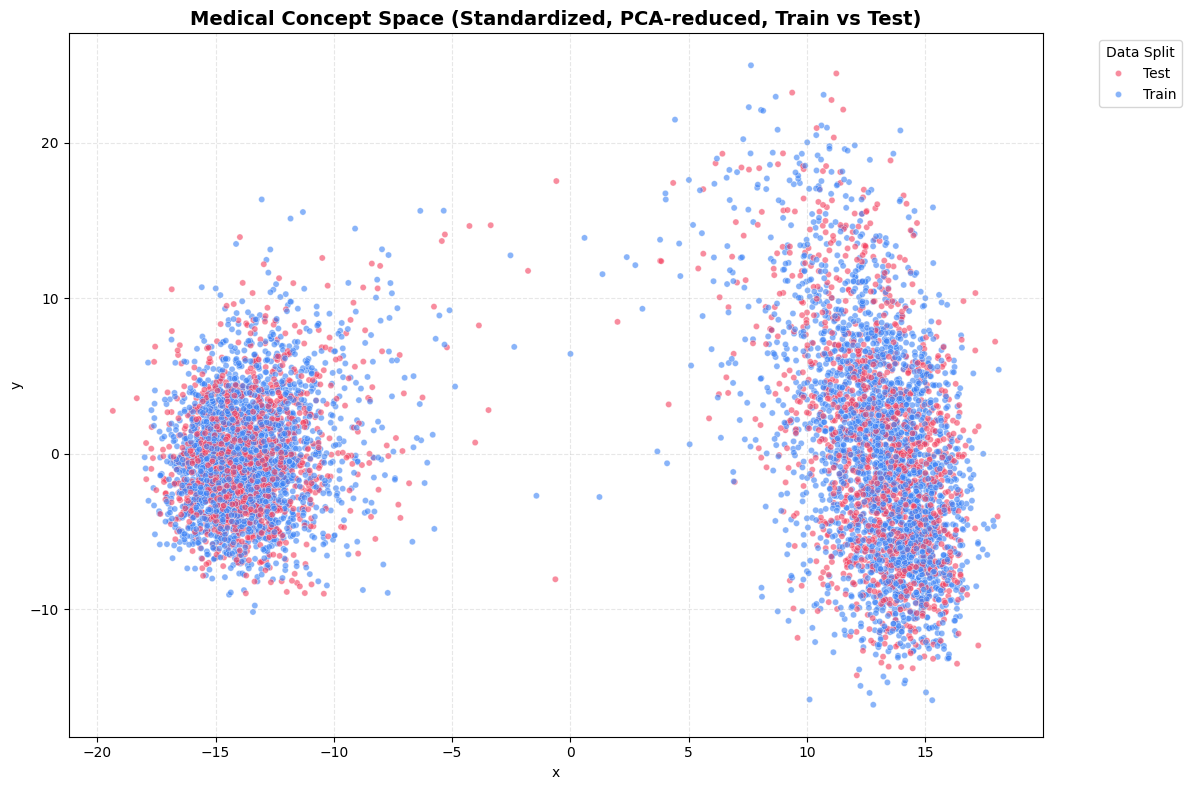

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

print("Visualizing standardized concept space (train vs test)...")

pca = PCA(n_components=2)
X_all_scaled = scaler.transform(X_all)  
X_pca = pca.fit_transform(X_all_scaled)

split_labels = ["Train" if i in train_indices else "Test" for i in range(len(X_all))]

df_viz = pd.DataFrame({
    "x": X_pca[:,0],
    "y": X_pca[:,1],
    "Split": split_labels
})

plt.figure(figsize=(12,8))
sns.scatterplot(
    data=df_viz, x="x", y="y", hue="Split",
    palette={"Train":"#3b82f6","Test":"#f43f5e"},
    alpha=0.6, s=20
)
plt.title("Medical Concept Space (Standardized, PCA-reduced, Train vs Test)", fontsize=14, fontweight='bold')
plt.legend(title="Data Split", bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


Plotting feature importances (top 10)...


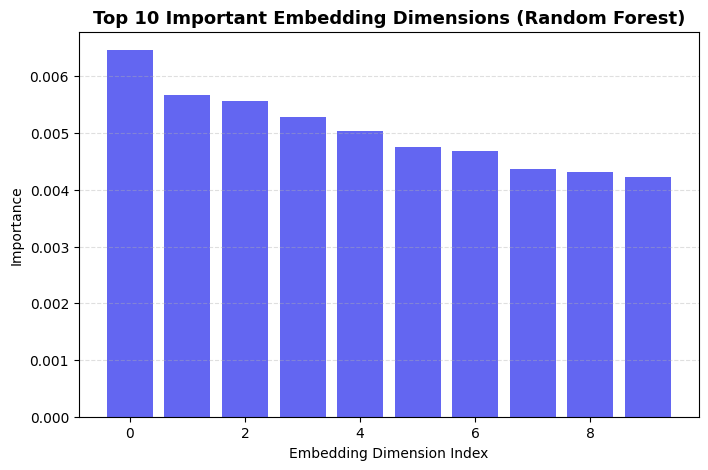

In [18]:
import numpy as np

print("Plotting feature importances (top 10)...")

importances = np.mean([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:10]

plt.figure(figsize=(8,5))
plt.bar(range(10), importances[indices], color="#6366f1")
plt.title("Top 10 Important Embedding Dimensions (Random Forest)", fontsize=13, fontweight='bold')
plt.xlabel("Embedding Dimension Index")
plt.ylabel("Importance")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


In [19]:
# Neuro-Symbolic Graph Construction

from rdflib import Graph, Literal, RDF, Namespace, URIRef
from rdflib.namespace import OWL, RDFS, SKOS

print("Building Hierarchical Neuro-Symbolic Knowledge Graph...")

g = Graph()
EX = Namespace("http://example.org/medical_project/")
g.bind("ex", EX)
g.bind("skos", SKOS)

# ---------------------------------------------------------
# 1. Medical definitions (domain knowledge)
# ---------------------------------------------------------
kg_definitions = {
    "Pneumonia": "Inflammation of the lung parenchyma/alveoli, often caused by infection.",
    "Cardiomegaly": "Enlargement of the cardiac silhouette, suggestive of heart failure or cardiomyopathy.",
    "PleuralEffusion": "Accumulation of fluid in the pleural cavity between the lung and chest wall.",
    "Edema": "Abnormal accumulation of fluid in the extravascular compartments of the lung.",
    "Atelectasis": "Reversible collapse of lung tissue with loss of volume.",
    "Fracture": "Disruption in the continuity of bone cortex, often due to trauma.",
    "Pneumothorax": "Presence of air in the pleural space causing lung collapse.",
    "Normal": "No acute radiographic cardiopulmonary abnormalities identified."
}

# ---------------------------------------------------------
# 2. Ontology schema definition
# ---------------------------------------------------------

# Define object properties
part_of = EX.isPartOf
located_in = EX.locatedIn
g.add((part_of, RDF.type, OWL.ObjectProperty))
g.add((part_of, RDF.type, OWL.TransitiveProperty)) 
# If A is part of B and B is part of C, then A is part of C
g.add((located_in, RDF.type, OWL.ObjectProperty))


# Define main classes
g.add((EX.Anatomy, RDF.type, OWL.Class))
g.add((EX.Pathology, RDF.type, OWL.Class)) 

# --- Additional layer: taxonomy of diseases ---

g.add((EX.LungPathology, RDFS.subClassOf, EX.Pathology))
g.add((EX.HeartPathology, RDFS.subClassOf, EX.Pathology))
g.add((EX.PleuralPathology, RDFS.subClassOf, EX.Pathology))
g.add((EX.BonePathology, RDFS.subClassOf, EX.Pathology))

# ---------------------------------------------------------
# 3. Anatomy tree (body structures)
# ---------------------------------------------------------

anatomy_specs = [
    ("Chest", None),
    ("Lung", "Chest"), ("RightLung", "Lung"), ("LeftLung", "Lung"),
    ("Heart", "Chest"), ("Mediastinum", "Chest"),
    ("PleuralSpace", "Chest"),
    ("Bones", "Chest"), ("Ribs", "Bones"), ("Spine", "Bones"), ("Clavicle", "Bones"),
    ("Diaphragm", "Chest")
]

for item, parent in anatomy_specs:
    item_uri = EX[item]
    g.add((item_uri, RDF.type, EX.Anatomy))
    if parent: g.add((item_uri, part_of, EX[parent]))

# ---------------------------------------------------------
# 4. Connect disease instances to anatomy and taxonomy
# ---------------------------------------------------------
# Format: (disease name, parent pathology class, anatomical locations, list of synonyms)
diseases_detailed = [
    ("Cardiomegaly", "HeartPathology", ["Heart"], ["Enlarged Heart", "CTR > 0.5"]),
    ("Pneumonia", "LungPathology", ["RightLung", "LeftLung"], ["Consolidation", "Infection", "Infiltration"]),
    ("Atelectasis", "LungPathology", ["RightLung", "LeftLung"], ["Lung Collapse", "Volume Loss"]),
    ("Edema", "LungPathology", ["RightLung", "LeftLung"], ["Pulmonary Edema", "Congestion", "Fluid Overload"]),
    ("PleuralEffusion", "PleuralPathology", ["PleuralSpace"], ["Fluid in Chest", "Blunting Costophrenic Angle"]),
    ("Pneumothorax", "PleuralPathology", ["PleuralSpace"], ["Air in Chest", "Collapsed Lung"]),
    ("Fracture", "BonePathology", ["Ribs", "Clavicle", "Spine"], ["Broken Bone", "Osseous Discontinuity"]),
    ("Normal", "Pathology", ["Chest"], ["No Acute Finding", "Unremarkable"])  # Connect the 'Normal' concept directly
]

for name, parent_class, locations, labels in diseases_detailed:
    disease_uri = EX[name]
    
    # 1. Type assignment (disease as instance of a pathology subclass)
    g.add((disease_uri, RDF.type, EX[parent_class])) # مثلا Pneumonia نوعی LungPathology است
    
    # 2. Anatomical location links
    for loc in locations:
        g.add((disease_uri, located_in, EX[loc]))
    
    # 3. Textual metadata (labels and definitions)
    g.add((disease_uri, SKOS.prefLabel, Literal(name)))
    if name in kg_definitions:
        g.add((disease_uri, SKOS.definition, Literal(kg_definitions[name])))
    
    for label in labels:
        g.add((disease_uri, SKOS.altLabel, Literal(label)))

# Final serialization
g.serialize(destination="medical_kg_comprehensive.ttl", format="turtle")
print(f"Hierarchical Knowledge Graph Built! Total Triples: {len(g)}")

Building Hierarchical Neuro-Symbolic Knowledge Graph...
Hierarchical Knowledge Graph Built! Total Triples: 87


In [20]:
#!pip install nltk scikit-learn

In [21]:
from sklearn.metrics import classification_report, f1_score, recall_score, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
import random
from tqdm.auto import tqdm

# Settings
TEST_SAMPLE_SIZE = 500
TOP_K = 3
CONFIDENCE_THRESHOLD = 0.25  

def smart_evaluation_multilabel():
    print(f"Running 'Neuro-Symbolic Evaluation' on {TEST_SAMPLE_SIZE} cases...")
    print(f"Strategy: Random Forest Prediction + Knowledge Retrieval")

    global df_final, clf, mlb, scaler, test_indices, all_embeddings_raw

    df_final.reset_index(drop=True, inplace=True)

    if 'test_indices' not in globals():
        raise ValueError("test_indices not found – make sure you ran the training cell with train_test_split.")

    # We only sample from the test set
    available_test = list(test_indices)
    n_samples = min(TEST_SAMPLE_SIZE, len(available_test))
    eval_indices = random.sample(available_test, n_samples)

    y_true_all = []
    y_pred_all = []
    hits = 0
    total_diseased = 0

    for idx in tqdm(eval_indices, desc="Evaluating"):
        query_row = df_final.iloc[idx]

        query_emb_raw = query_row['embedding'].reshape(1, -1)
        query_emb_scaled = scaler.transform(query_emb_raw)

        true_labels = set(query_row['detected_entities'])
        true_labels = {x for x in true_labels if x in mlb.classes_}
        if not true_labels:
            true_labels = {"Normal"}

        # A. prediction
        probs = predict_proba_calibrated(query_emb_scaled)[0]

        predicted_indices = np.where(probs > CONFIDENCE_THRESHOLD)[0]
        predicted_labels_neural = [mlb.classes_[i] for i in predicted_indices] if len(predicted_indices) > 0 else ["Normal"]

        if len(predicted_labels_neural) > 1 and "Normal" in predicted_labels_neural:
            predicted_labels_neural.remove("Normal")
        if not predicted_labels_neural:
            predicted_labels_neural = ["Normal"]

        # B. Retrieval step (for explanation only; no leakage into training)
        # (Note: retrieval is used only for case-based explanation, not for changing the prediction.)
        search_indices = np.arange(len(df_final))
        if "Normal" not in predicted_labels_neural:
            mask = df_final['detected_entities'].apply(lambda x: any(d in x for d in predicted_labels_neural))
            if mask.sum() > 5:
                search_indices = df_final[mask].index.to_numpy()

        search_embeddings = all_embeddings_raw[search_indices]
        sims = cosine_similarity(query_emb_raw, search_embeddings)[0]
        top_local_idxs = sims.argsort()[::-1][:TOP_K+1]

        final_prediction = set(predicted_labels_neural)

        y_true_all.append(list(true_labels))
        y_pred_all.append(list(final_prediction))

        if "Normal" not in true_labels:
            total_diseased += 1
            if not true_labels.isdisjoint(final_prediction):
                hits += 1

    

    # Reporting
    y_true_bin = mlb.transform(y_true_all)
    y_pred_bin = mlb.transform(y_pred_all)
    
    print("\n" + "="*60)
    print("NEURO-SYMBOLIC MODEL PERFORMANCE REPORT (SCALED)")
    print("="*60)
    
    micro_f1 = f1_score(y_true_bin, y_pred_bin, average='micro')
    macro_f1 = f1_score(y_true_bin, y_pred_bin, average='macro')
    recall = recall_score(y_true_bin, y_pred_bin, average='macro')
    
    print(f"Diagnostic Hit Rate: {hits/total_diseased:.2%}" if total_diseased > 0 else "N/A")
    print(f"Micro F1-Score: {micro_f1:.2%}")
    print(f"Macro F1-Score: {macro_f1:.2%}")
    print(f"Macro Recall: {recall:.2%}")
    
    print("\nDetailed Report per Disease:")
    print(classification_report(y_true_bin, y_pred_bin, target_names=mlb.classes_, zero_division=0))
    print("="*60)

# Run
smart_evaluation_multilabel()

Running 'Neuro-Symbolic Evaluation' on 500 cases...
Strategy: Random Forest Prediction + Knowledge Retrieval


Evaluating: 100%|██████████| 500/500 [03:17<00:00,  2.53it/s]


NEURO-SYMBOLIC MODEL PERFORMANCE REPORT (SCALED)
Diagnostic Hit Rate: 17.29%
Micro F1-Score: 67.88%
Macro F1-Score: 23.00%
Macro Recall: 20.41%

Detailed Report per Disease:
                 precision    recall  f1-score   support

   Cardiomegaly       0.31      0.17      0.22        24
      Pneumonia       0.33      0.19      0.24        74
    Atelectasis       0.62      0.23      0.33        44
          Edema       0.50      0.08      0.13        13
PleuralEffusion       1.00      0.04      0.07        26
       Fracture       0.00      0.00      0.00        10
   Pneumothorax       0.00      0.00      0.00        20
         Normal       0.77      0.93      0.84       367

      micro avg       0.72      0.65      0.68       578
      macro avg       0.44      0.20      0.23       578
   weighted avg       0.65      0.65      0.61       578
    samples avg       0.72      0.72      0.72       578



In [22]:
from tqdm.auto import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_normal_vs_threshold_fast(thresholds):
    global X_test_scaled_global, y_test_global, clf, mlb

    print(f"Test samples: {X_test_scaled_global.shape[0]}")
    print(f"Thresholds to evaluate: {thresholds}")

    # 1) Run predict_proba once on the entire test set
    print("Running predict_proba on full test set (one pass)...")
    probs_all = predict_proba_calibrated(X_test_scaled_global)   

    # Index of the 'Normal' class in mlb
    normal_idx = list(mlb.classes_).index("Normal")

    # True label for 'Normal': only if the sample is single-label and that label is 'Normal'
    y_true_normal = (
        (y_test_global[:, normal_idx] == 1) &
        (y_test_global.sum(axis=1) == 1)
    ).astype(int)

    results = []

    # 2) Threshold sweep (very cheap; no extra predict_proba call)
    for thr in tqdm(thresholds, desc="Threshold sweep"):
        y_pred_normal = []

        for probs in probs_all:
            # Apply the global threshold across all classes
            pred_indices = np.where(probs > thr)[0]

            if len(pred_indices) > 0:
                pred_labels = [mlb.classes_[i] for i in pred_indices]

                # If any pathology is present, drop 'Normal' from predictions
                if len(pred_labels) > 1 and "Normal" in pred_labels:
                    pred_labels.remove("Normal")
                if not pred_labels:
                    pred_labels = ["Normal"]
            else:
                pred_labels = ["Normal"]

            pred_normal = (pred_labels == ["Normal"])
            y_pred_normal.append(1 if pred_normal else 0)

        # 3) Metrics for the 'Normal' class at this threshold
        p = precision_score(y_true_normal, y_pred_normal, zero_division=0)
        r = recall_score(y_true_normal, y_pred_normal, zero_division=0)
        f1 = f1_score(y_true_normal, y_pred_normal, zero_division=0)

        results.append((thr, p, r, f1))

    return results

# Run
thresholds = [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5]
normal_results = evaluate_normal_vs_threshold_fast(thresholds)

for thr, p, r, f1 in normal_results:
    print(f"Threshold={thr:.2f} | P={p:.2f} R={r:.2f} F1={f1:.2f}")


Test samples: 1486
Thresholds to evaluate: [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5]
Running predict_proba on full test set (one pass)...


Threshold sweep: 100%|██████████| 7/7 [00:00<00:00, 111.31it/s]

Threshold=0.15 | P=0.85 R=0.76 F1=0.81
Threshold=0.20 | P=0.82 R=0.88 F1=0.85
Threshold=0.25 | P=0.81 R=0.94 F1=0.87
Threshold=0.30 | P=0.79 R=0.96 F1=0.87
Threshold=0.35 | P=0.79 R=0.97 F1=0.87
Threshold=0.40 | P=0.78 R=0.98 F1=0.87
Threshold=0.50 | P=0.78 R=0.99 F1=0.87


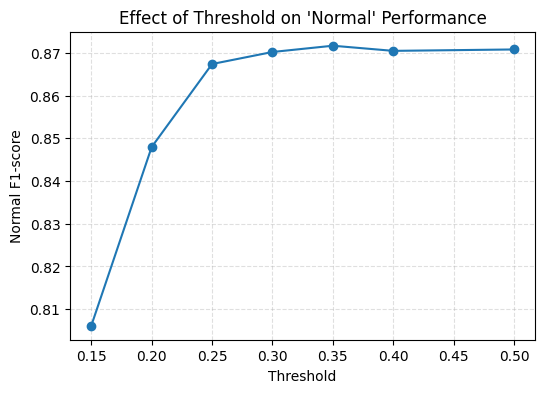

In [23]:
ths = [r[0] for r in normal_results]
f1s = [r[3] for r in normal_results]

plt.figure(figsize=(6,4))
plt.plot(ths, f1s, marker="o")
plt.xlabel("Threshold")
plt.ylabel("Normal F1-score")
plt.title("Effect of Threshold on 'Normal' Performance")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()


Counter({('Normal',): 1136, ('Pneumonia',): 80, ('Atelectasis',): 55, ('PleuralEffusion', 'Pneumonia', 'Pneumothorax'): 35, ('Atelectasis', 'Pneumonia'): 33, ('Cardiomegaly',): 33, ('Fracture',): 22, ('PleuralEffusion',): 12, ('Edema',): 9, ('Cardiomegaly', 'Edema'): 6, ('Edema', 'Pneumonia'): 6, ('PleuralEffusion', 'Pneumonia'): 5, ('Atelectasis', 'PleuralEffusion', 'Pneumonia'): 5, ('Atelectasis', 'PleuralEffusion'): 4, ('Cardiomegaly', 'Edema', 'Pneumonia'): 4, ('Atelectasis', 'Cardiomegaly', 'Pneumonia'): 4, ('PleuralEffusion', 'Pneumothorax'): 3, ('Atelectasis', 'Fracture', 'Pneumonia'): 3, ('Cardiomegaly', 'Edema', 'PleuralEffusion'): 2, ('Atelectasis', 'Edema', 'Pneumonia'): 2, ('Pneumonia', 'Pneumothorax'): 2, ('Atelectasis', 'Fracture', 'PleuralEffusion'): 2, ('Fracture', 'PleuralEffusion', 'Pneumonia', 'Pneumothorax'): 2, ('Cardiomegaly', 'Pneumonia'): 2, ('Atelectasis', 'PleuralEffusion', 'Pneumonia', 'Pneumothorax'): 2, ('Cardiomegaly', 'Fracture', 'Pneumothorax'): 2, ('Ede

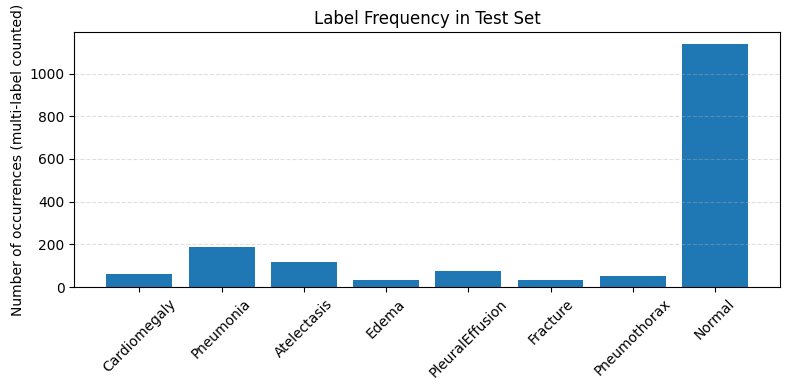

In [24]:
from collections import Counter


# Convert the results to a NumPy array of objects before passing to Counter
results_array = np.array([tuple(sorted(i)) for i in mlb.inverse_transform(y_test)], dtype=object)

# Use the object array with Counter
label_counts = Counter(results_array)
print(label_counts)
# Count per-disease frequency in the test set (multi-label counts)
single_label_counts = {d: 0 for d in TARGET_DISEASES}

for combo, cnt in label_counts.items():
    for d in combo:
        single_label_counts[d] += cnt

print(single_label_counts)

# Convert to DataFrame-friendly format for plotting
labels = list(single_label_counts.keys())
values = [single_label_counts[d] for d in labels]

plt.figure(figsize=(8,4))
plt.bar(labels, values)
plt.title("Label Frequency in Test Set")
plt.ylabel("Number of occurrences (multi-label counted)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [25]:
from sklearn.metrics import hamming_loss, accuracy_score, jaccard_score

# 1) Probability of once on test
probs_all = predict_proba_calibrated(X_test_scaled_global)

# 2) Only Diseases without normal
classes = np.array(mlb.classes_)
mask_pathologies = classes != "Normal"

y_test_path = y_test_global[:, mask_pathologies]
probs_path = probs_all[:, mask_pathologies]

THR_MAIN = 0.25  
y_pred_path = (probs_path > THR_MAIN).astype(int)

# 3) Metrics
hamming = hamming_loss(y_test_path, y_pred_path)
subset_acc = accuracy_score(y_test_path, y_pred_path)
jacc_micro = jaccard_score(y_test_path, y_pred_path, average='micro')
jacc_macro = jaccard_score(y_test_path, y_pred_path, average='macro')

print(f"Hamming loss (pathologies):  {hamming:.3f}")
print(f"Subset accuracy:             {subset_acc:.3f}")
print(f"Jaccard (micro):             {jacc_micro:.3f}")
print(f"Jaccard (macro):             {jacc_macro:.3f}")


Hamming loss (pathologies):  0.062
Subset accuracy:             0.727
Jaccard (micro):             0.100
Jaccard (macro):             0.068


In [26]:
from sklearn.metrics import roc_auc_score

auc_per_class = roc_auc_score(
    y_test_path,      
    probs_path,       
    average=None
)

for name, auc in zip(classes[mask_pathologies], auc_per_class):
    print(f"{name:15s} AUC = {auc:.3f}")


Cardiomegaly    AUC = 0.816
Pneumonia       AUC = 0.672
Atelectasis     AUC = 0.804
Edema           AUC = 0.776
PleuralEffusion AUC = 0.600
Fracture        AUC = 0.558
Pneumothorax    AUC = 0.533


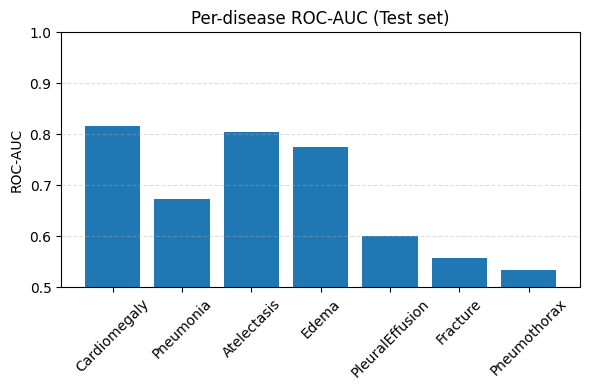

In [27]:
plt.figure(figsize=(6,4))
plt.bar(classes[mask_pathologies], auc_per_class)
plt.ylabel("ROC-AUC")
plt.title("Per-disease ROC-AUC (Test set)")
plt.xticks(rotation=45)
plt.ylim(0.5, 1.0)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [28]:
database_embeddings = X_all

def compute_hit_at_k(k=3, max_cases=300):
    # Use at most max_cases samples from test_indices
    eval_ids = test_indices[:max_cases]
    
    hits = 0
    total = 0
    
    for idx in tqdm(eval_ids, desc=f"Hit@{k}"):
        query_row = df_final.iloc[idx]
        q_emb = query_row['embedding'].reshape(1, -1)
        true_labels = set(query_row['detected_entities'])
        
        sims = cosine_similarity(q_emb, database_embeddings)[0]
        order = sims.argsort()[::-1]
        
        top = []
        for j in order:
            if j == idx:  
                continue
            top.append(j)
            if len(top) == k:
                break
        
        # Check if there is at least one shared label between the query and retrieved cases
        ok = False
        for j in top:
            labs_j = set(df_final.iloc[j]['detected_entities'])
            if not true_labels.isdisjoint(labs_j):
                ok = True
                break
        
        hits += 1 if ok else 0
        total += 1
    
    return hits / total

for k in [1, 3, 5]:
    print(f"Hit@{k}: {compute_hit_at_k(k)*100:.1f}%")


Hit@1: 100%|██████████| 300/300 [00:04<00:00, 64.57it/s]


Hit@1: 66.3%


Hit@3: 100%|██████████| 300/300 [00:04<00:00, 64.48it/s]


Hit@3: 83.3%


Hit@5: 100%|██████████| 300/300 [00:04<00:00, 64.75it/s]

Hit@5: 86.0%


Hit@5: 100%|██████████| 300/300 [00:04<00:00, 62.06it/s]


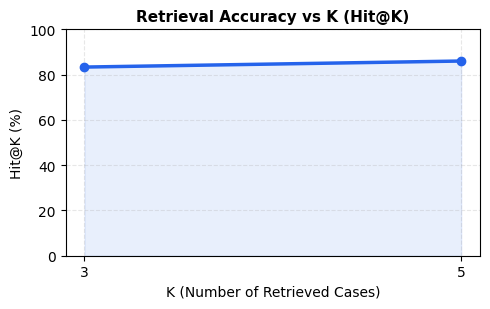

In [29]:
import matplotlib.pyplot as plt

# Values taken from the retrieval evaluation output
k_values = [3, 5]
hit_scores = []
for k in k_values:
    score = compute_hit_at_k(k) * 100
    hit_scores.append(score)


plt.figure(figsize=(5, 3.2))
plt.plot(k_values, hit_scores, marker='o', linewidth=2.5, color="#2563eb")
plt.fill_between(k_values, hit_scores, alpha=0.1, color="#2563eb")
plt.title("Retrieval Accuracy vs K (Hit@K)", fontsize=11, fontweight="bold")
plt.xlabel("K (Number of Retrieved Cases)")
plt.ylabel("Hit@K (%)")
plt.ylim(0, 100)
plt.xticks(k_values)
plt.grid(alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()


In [30]:
#!pip install openai

In [31]:
# Cell - Generative AI Report Drafting (RAG - Multi-Label Supported)

import openai
import datetime

def generate_report_draft(predicted_diseases, similar_reports_text, api_key=None):
    """
    Advanced version: supports multiple diseases at once and can generate
    a structured report either with an LLM (online) or with an offline template.
    """
    
    # Ensure the input is a list of diseases
    if isinstance(predicted_diseases, str):
        # If a plain string accidentally comes in (for backward compatibility), convert it into a one-element list
        predicted_diseases = [predicted_diseases]
    
    # Remove 'Normal' if there are other pathologies in the list (cleanup)
    if len(predicted_diseases) > 1 and "Normal" in predicted_diseases:
        predicted_diseases = [d for d in predicted_diseases if d != "Normal"]
        
    disease_str = ", ".join(predicted_diseases)
    
    # ---------------------------------------------------------
    # If an API key is provided
    # ---------------------------------------------------------
    if api_key:
        prompt = f"""
        Role: You are an expert Radiologist.
        Task: Write a chest X-ray report based on the AI detection and similar past cases.
        
        AI Detected Pathology: {disease_str}
        
        Context from Similar Cases (RAG):
        {similar_reports_text}
        
        Instructions:
        - Write a professional 'Findings' section describing the detected pathology.
        - Write an 'Impression' section summarizing the diagnosis.
        - If 'Normal' is detected, write a standard normal report.
        - Be concise and medically accurate.
        """
        try:
            client = openai.OpenAI(api_key=api_key)
            response = client.chat.completions.create(
                model="gpt-3.5-turbo",
                messages=[{"role": "user", "content": prompt}],
                temperature=0.3
            )
            return response.choices[0].message.content
        except Exception as e:
            return f"API Error: {e}\n(Switching to Offline Template...)\n\n" + _generate_offline_template(predicted_diseases)

    # ---------------------------------------------------------
    # Case 2: Offline rule-based template generation
    # ---------------------------------------------------------
    else:
        return _generate_offline_template(predicted_diseases)

def _generate_offline_template(diseases):
    """Internal helper function to build a report without any external API."""
    
    # 1. Heart section
    heart_text = "The cardiac silhouette is normal in size."
    if "Cardiomegaly" in diseases:
        heart_text = "The cardiac silhouette is moderately enlarged (Cardiomegaly)."
        
    # 2. Lung section
    lung_findings = []
    if "Pneumonia" in diseases: lung_findings.append("focal consolidation consistent with pneumonia")
    if "Edema" in diseases: lung_findings.append("vascular congestion and interstitial edema")
    if "Atelectasis" in diseases: lung_findings.append("linear opacity suggestive of atelectasis")
    if "Normal" in diseases: lung_findings.append("clear fields bilaterally")
    
    lung_text = f"The lungs show {', '.join(lung_findings)}." if lung_findings else "Lungs are clear."
    
    # 3. Pleural space section
    pleura_text = "No pleural effusion or pneumothorax is seen."
    pleura_findings = []
    if "PleuralEffusion" in diseases: pleura_findings.append("blunting of the costophrenic angle (effusion)")
    if "Pneumothorax" in diseases: pleura_findings.append("visible pleural line indicating pneumothorax")
    
    if pleura_findings:
        pleura_text = f"There is {', '.join(pleura_findings)}."
        
    # 4. Bones and thoracic cage
    bone_text = "Osseous structures are intact."
    if "Fracture" in diseases:
        bone_text = "An acute fracture is noted involving the bony thorax."

    # Final formatted report
    report = f"""
    --- AI-GENERATED PRELIMINARY REPORT ---
    
    FINDINGS:
    {heart_text} {lung_text} {pleura_text}
    {bone_text} The mediastinal contours are unremarkable.
    
    IMPRESSION:
    1. Findings consistent with {", ".join(diseases).upper()}.
    2. Clinical correlation recommended.
    ---------------------------------------
    """
    return report

# --- Test---
print("Testing Multi-Label Report Generation...")
test_input = ["Pneumonia", "Cardiomegaly"] 
test_context = "Patient has history of cough..."

print(generate_report_draft(test_input, test_context))

Testing Multi-Label Report Generation...

    --- AI-GENERATED PRELIMINARY REPORT ---
    
    FINDINGS:
    The cardiac silhouette is moderately enlarged (Cardiomegaly). The lungs show focal consolidation consistent with pneumonia. No pleural effusion or pneumothorax is seen.
    Osseous structures are intact. The mediastinal contours are unremarkable.
    
    IMPRESSION:
    1. Findings consistent with PNEUMONIA, CARDIOMEGALY.
    2. Clinical correlation recommended.
    ---------------------------------------
    


In [32]:
def build_radiology_prompt(predicted_labels_text, rag_context_text, kg_definitions):
    """
    predicted_labels_text: مثل 'Cardiomegaly, Edema, Fracture'
    rag_context_text: خلاصه گزارش‌های موارد مشابه
    kg_definitions: دیکشنری {disease: definition}
    """
    kg_str_lines = []
    for d, definition in kg_definitions.items():
        kg_str_lines.append(f"- {d}: {definition}")
    kg_block = "\n".join(kg_str_lines)

    prompt = f"""
You are an assistant radiologist. You generate chest X-ray reports in clear, concise English.

PREDICTED DIAGNOSES (from a multi-label classifier):
{predicted_labels_text}

SIMILAR CASES CONTEXT (radiology reports from similar images):
{rag_context_text}

KNOWLEDGE GRAPH FACTS (disease definitions):
{kg_block}

TASK:
Write a structured chest X-ray report with two sections:

FINDINGS:
- Sentences describing the heart, lungs, pleura, bones, and any devices or lines.
- Be specific but not speculative. Do not hallucinate anatomy that is impossible.

IMPRESSION:
- 1–3 bullet points summarizing the key diagnoses and recommendations.
- Use the predicted diagnoses if they are consistent with the context.

Rules:
- Do not mention that you are an AI.
- Do not include patient name or age.
- Keep it short and clinically realistic.
"""
    return prompt.strip()


In [33]:
import os
import re
from openai import OpenAI

# ==========================================
# 1. Setup Local LLM Client (Ollama)
# ==========================================
# Connects to the local Ollama instance running DeepSeek-R1
client = OpenAI(
    base_url='http://localhost:11434/v1',
    api_key='ollama',  # Placeholder key required by the library
)

# ==========================================
# 2. Prompt Builder Function
# ==========================================
def build_radiology_prompt(predicted_labels_text, rag_context_text, kg_definitions):
    """
    Constructs the prompt for the LLM specifically for Radiology Report Generation.
    
    Args:
        predicted_labels_text (str): Diseases detected by the Vision Model/Classifier.
        rag_context_text (str): Retrievel text from similar cases (RAG).
        kg_definitions (dict): Knowledge Graph definitions/rules.
    """
    
    # Format Knowledge Graph definitions into a bulleted list
    kg_str_lines = []
    for d, definition in kg_definitions.items():
        kg_str_lines.append(f"- {d}: {definition}")
    kg_block = "\n".join(kg_str_lines)

    prompt = f"""
You are an expert radiologist assistant. Your task is to generate a professional chest X-ray report.

INPUT DATA:
1. PREDICTED PATHOLOGIES (from Vision Model):
{predicted_labels_text}

2. SIMILAR CASES CONTEXT (from RAG System):
{rag_context_text}

3. MEDICAL KNOWLEDGE RULES (Fact-Checking):
{kg_block}

INSTRUCTIONS:
- Write a structured report with two sections: "FINDINGS" and "IMPRESSION".
- In "FINDINGS": Describe the heart, lungs, and bones clearly. Mention normal areas if applicable.
- In "IMPRESSION": Summarize the diagnosis concisely.
- STRICT RULE: Use the provided Medical Knowledge Rules to ensure anatomical correctness.
- Do not mention that you are an AI. Do not output your internal thinking process.
"""
    return prompt.strip()

# ==========================================
# 3. Report Generation Function (DeepSeek)
# ==========================================
def generate_report_draft(predicted_labels_text, rag_context_text, kg_definitions):
    """
    Calls the local DeepSeek-R1 model to generate the final report.
    Includes post-processing to remove 'Chain of Thought' traces.
    """
    
    # Build the prompt
    prompt = build_radiology_prompt(predicted_labels_text, rag_context_text, kg_definitions)

    try:
        # Call the local model
        response = client.chat.completions.create(
            model="deepseek-r1:latest",  # Using your specific local model
            messages=[
                {"role": "user", "content": prompt},
            ],
            temperature=0.3, # Low temperature for more factual/deterministic outputs
            max_tokens=1000,
        )
        
        raw_content = response.choices[0].message.content

        # DeepSeek-R1 often outputs <think> tags. We must remove them for the UI.
        # This regex removes everything between <think> and </think>
        clean_content = re.sub(r'<think>.*?</think>', '', raw_content, flags=re.DOTALL).strip()
        
        return clean_content

    except Exception as e:
        return f"[Error] Could not connect to Ollama or generate report: {str(e)}"

In [34]:
test_labels = "Cardiomegaly, Pneumonia"
test_context = "Similar Case 1: left lower lobe consolidation consistent with pneumonia.\n"
test_report = generate_report_draft(test_labels, test_context, kg_definitions)
print(test_report)


**FINDINGS:**

Cardiomegaly is noted. The cardiac silhouette is enlarged.

The lungs show evidence of pneumonia. Specifically, there is consolidation in the left lower lobe, consistent with the similar case. This is characterized by airspace opacity with loss of lung volume and the bronchial air sign. The right upper lobe/hilum and the lingula appear relatively spared, representing normal areas.

Bone structures are unremarkable. No acute fracture or other osseous abnormalities are identified.

**IMPRESSION:**

Cardiomegaly. Pneumonia, left lower lobe consolidation.


Reloading BiomedCLIP model for the dashboard...


c:\Users\ASUS\.conda\envs\clean_env\lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Model ready.
Testing with a Pneumonia case...



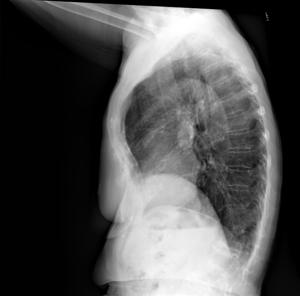
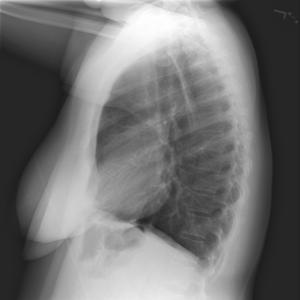
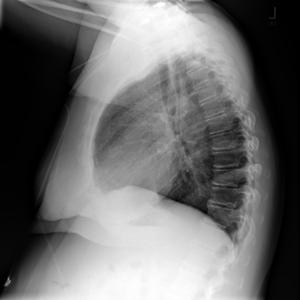
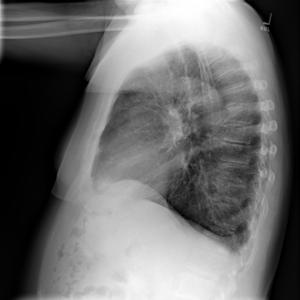

In [35]:
# Cell Final - Dashboard (Updated for Multi-Label Random Forest)

import html
import base64
import uuid
import torch
import open_clip
from io import BytesIO
from PIL import Image
from IPython.display import display, HTML
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# -------------------------------------------------------------
# 1. Reload model (to avoid errors after clearing memory)
# -------------------------------------------------------------
print("Reloading BiomedCLIP model for the dashboard...")
try:
    device = "cpu"
    if 'model' not in globals():
        model, _, preprocess = open_clip.create_model_and_transforms('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
        model.to(device)
        model.eval()
    print("Model ready.")
except Exception as e:
    print(f"Error reloading model: {e}")

# Embedding wrapper for the dashboard (using the same scaler as in training)
def get_embedding_for_dashboard(image_path):
    try:
        img = Image.open(image_path).convert("RGB")
        image_input = preprocess(img).unsqueeze(0).to("cpu")
        with torch.no_grad():
            emb = model.encode_image(image_input)
            emb /= emb.norm(dim=-1, keepdim=True)
        return emb.cpu().numpy().flatten()
    except:
        return np.zeros(512)

# Ensure knowledge-graph definitions are available
if 'kg_definitions' not in globals():
    kg_definitions = {} 

# -------------------------------------------------------------
# 2. Auxiliary functions (image conversion and text highlighting)
# -------------------------------------------------------------
def image_to_base64(img_path):
    try:
        img = Image.open(img_path).convert("RGB")
        img.thumbnail((300, 300))
        buffered = BytesIO()
        img.save(buffered, format="JPEG")
        img_str = base64.b64encode(buffered.getvalue()).decode()
        return f"data:image/jpeg;base64,{img_str}"
    except:
        return ""

def highlight_medical_concepts(text, entities):
    # Color map for highlighting entities
    color_map = {
        "Cardiomegaly": ("#fee2e2", "#991b1b"), "Pneumonia": ("#dbeafe", "#1e40af"),
        "Edema": ("#e0e7ff", "#3730a3"), "PleuralEffusion": ("#fef3c7", "#92400e"),
        "Atelectasis": ("#f3e8ff", "#6b21a8"), "Fracture": ("#fce7f3", "#9d174d"),
        "Pneumothorax": ("#ffedd5", "#c2410c"), "Normal": ("#dcfce7", "#166534")
    }
    # Mapping of textual keywords in the report to disease concepts (for highlighting)
    keyword_map = {
        # قلب
        # Heart-related concepts
        "cardiomegaly": "Cardiomegaly", 
        "enlarged heart": "Cardiomegaly", 
        "heart enlargement": "Cardiomegaly", 
        "cardiac enlargement": "Cardiomegaly", 
        "prominent cardiac silhouette": "Cardiomegaly", 
        "ctr > 0.5": "Cardiomegaly",
        
        # ذات‌الریه و عفونت
        # Pneumonia and infectious patterns
        "pneumonia": "Pneumonia", 
        "infection": "Pneumonia", 
        "consolidation": "Pneumonia", 
        "airspace disease": "Pneumonia", 
        "infiltration": "Pneumonia", 
        "opacities": "Pneumonia", 
        "hazy opacity": "Pneumonia",
        
        # آتلتکتازی
        # Atelectasis-related patterns
        "atelectasis": "Atelectasis", 
        "collapse": "Atelectasis", 
        "volume loss": "Atelectasis", 
        "plate-like opacity": "Atelectasis",
        
        # ادم ریوی
        # Pulmonary edema and congestion
        "edema": "Edema", 
        "fluid overload": "Edema", 
        "congestion": "Edema", 
        "pulmonary edema": "Edema", 
        "vascular congestion": "Edema", 
        "kerley b lines": "Edema", 
        "peribronchial cuffing": "Edema",
        
        # پلورال افیوژن
        # Pleural effusion
        "pleural effusion": "PleuralEffusion", 
        "effusion": "PleuralEffusion", 
        "fluid in chest": "PleuralEffusion", 
        "blunting of costophrenic": "PleuralEffusion", 
        "meniscus sign": "PleuralEffusion",
        
        # پنوموتوراکس
        # Pneumothorax
        "pneumothorax": "Pneumothorax", 
        "air in chest": "Pneumothorax", 
        "pleural line": "Pneumothorax", 
        "lucency": "Pneumothorax",
        
        # شکستگی
        # Fracture-related findings
        "fracture": "Fracture", 
        "broken": "Fracture", 
        "deformity": "Fracture", 
        "osseous discontinuity": "Fracture", 
        "callus": "Fracture", 
        "rib fracture": "Fracture",
        
        # نرمال
        # Normal / no acute disease
        "normal": "Normal", 
        "no acute": "Normal", 
        "clear": "Normal", 
        "unremarkable": "Normal", 
        "intact": "Normal", 
        "stable": "Normal", 
        "within normal limits": "Normal", 
        "grossly normal": "Normal"
        }
    words = text.split()
    highlighted_words = []
    for word in words:
        clean_word = word.lower().strip(".,")
        matched_concept = None
        for key, concept in keyword_map.items():
            if key in clean_word: matched_concept = concept; break
        
        if matched_concept and matched_concept in entities:
            bg, fg = color_map.get(matched_concept, ("#f3f4f6", "#000"))
            definition = kg_definitions.get(matched_concept, "Medical Condition")
            word = f"""<span class="custom-tooltip" style="background-color: {bg}; color: {fg};">{word}<span class="tooltip-text">{definition}</span></span>"""
        highlighted_words.append(word)
    return " ".join(highlighted_words)

# -------------------------------------------------------------
# 3. Main dashboard function (with multi-label support)
# -------------------------------------------------------------
def generate_interactive_dashboard(query_image_path):
    unique_id = str(uuid.uuid4())[:8]
    
    # 1. Generating embedding on input
    query_emb_raw = get_embedding_for_dashboard(query_image_path)
    
    # 2. AI prediction (multi-label Random Forest, calibrated with the scaler)
    ai_predicted_diseases_list = []
    confidence = 0.0
    
    if 'clf' in globals() and 'mlb' in globals() and 'scaler' in globals():
        # Input scaling (very important because the model is trained with scaled data)
        features = query_emb_raw.reshape(1, -1)
        features_scaled = scaler.transform(features)
        
        # Taking Probabilities
        probs = predict_proba_calibrated(features_scaled)[0]
        
        
        predicted_indices = np.where(probs > 0.25)[0]
        
        if len(predicted_indices) > 0:
            ai_predicted_diseases_list = [mlb.classes_[i] for i in predicted_indices]
            confidence = np.mean([probs[i] for i in predicted_indices]) 
        else:
            ai_predicted_diseases_list = ["Normal"]
            confidence = probs.max() 
    else:
        ai_predicted_diseases_list = ["Unknown Model"]
    
    # Convert list to text for display
    ai_predicted_display = ", ".join(ai_predicted_diseases_list)

    # 3. Case retrieval based on raw embeddings
    database_embeddings = np.stack(df_final['embedding'].values)
    sims = cosine_similarity(query_emb_raw.reshape(1, -1), database_embeddings)[0]
    
    #Find the top-3 most similar cases in the database
    top_indices_raw = sims.argsort()[::-1]
    top_k_indices = []
    for idx in top_indices_raw:
        # Avoid returning the query image itself, if it is present in the database
        if sims[idx] < 0.9999: top_k_indices.append(idx)
        if len(top_k_indices) == 3: break
            
   # 4. Prepare tab contents and RAG context
    tabs_content_html = ""
    rag_context_text = "" 
    
    for rank, idx in enumerate(top_k_indices):
        match_row = df_final.iloc[idx]
        score = sims[idx]
        match_b64 = image_to_base64(match_row['image_path'])
        detected_diseases = match_row['detected_entities'] if isinstance(match_row['detected_entities'], list) else ["Normal"]
        
        rag_context_text += f"Similar Case {rank+1}: {match_row['caption']}\n"
        
        colored_report = highlight_medical_concepts(match_row['caption'], detected_diseases)
        
        # Creating knowledge graph tags
        kg_section_html = ""
        for disease in set(detected_diseases):
            definition = kg_definitions.get(disease, "Medical condition.")
            if disease == "Normal":
                kg_section_html += f"""<div class="kg-card normal custom-tooltip"><span class="kg-icon"></span><div><b>Normal</b></div><span class="tooltip-text">{definition}</span></div>"""
            else:
                icon = "" if disease in ["Pneumonia", "Atelectasis", "Pneumothorax"] else "" if disease == "Cardiomegaly" else ""
                kg_section_html += f"""<div class="kg-card disease custom-tooltip"><span class="kg-icon">{icon}</span><div><b>{disease}</b></div><span class="tooltip-text">{definition}</span></div>"""

        display_style = "block" if rank == 0 else "none"
        
        tabs_content_html += f"""
        <div id="result-{unique_id}-{rank}" style="display: {display_style}; animation: fadeIn 0.4s;">
            <div class="panel-header">
                <div style="display:flex; align-items:center; gap:10px;">
                    <span>Match #{rank+1}</span>
                    <button class="copy-btn" onclick="copyToClipboard('report-text-{unique_id}-{rank}')"></button>
                </div>
                <span class="score-badge">{score:.1%} Similarity</span>
            </div>
            <div style="display: flex; gap: 12px; margin-bottom: 10px; align-items: center; background: #f8fafc; padding: 10px; border-radius: 8px;">
                <img src="{match_b64}" class="ref-img">
                <div style="font-size: 0.8em; color: #475569;"><b>Visual Reference</b></div>
            </div>
            <div id="report-text-{unique_id}-{rank}" class="report-box">{colored_report}</div>
            <div style="margin-top: 10px; display: flex; gap: 5px; flex-wrap: wrap;">{kg_section_html}</div>
        </div>
        """

    # 5. Generate the final AI report (RAG + template)
    # If the report-generation function is not defined, fall back to a simple note
    if 'generate_report_draft' in globals() and callable(generate_report_draft):
        ai_draft_text = generate_report_draft(ai_predicted_display, rag_context_text, kg_definitions)
    else:
        ai_draft_text = "<b>Note:</b> RAG function not detected. To see the AI-generated report here, please create the 'generate_report_draft' function."

    query_b64 = image_to_base64(query_image_path)
    
    
    header_color = "#10b981" if "Normal" in ai_predicted_diseases_list and len(ai_predicted_diseases_list) == 1 else "#ef4444"

    js_script = f"""
    <script>
    function switchTab_{unique_id}(tabIndex) {{
        for(let i=0; i<3; i++) {{
            document.getElementById('result-{unique_id}-'+i).style.display = 'none';
            document.getElementById('btn-{unique_id}-'+i).classList.remove('active-tab');
        }}
        document.getElementById('result-{unique_id}-'+tabIndex).style.display = 'block';
        document.getElementById('btn-{unique_id}-'+tabIndex).classList.add('active-tab');
    }}
    function copyToClipboard(elementId) {{
        const text = document.getElementById(elementId).innerText;
        navigator.clipboard.writeText(text).then(() => {{ alert("Copied!"); }});
    }}
    </script>
    """

    # HTML Layout
    html_content = f"""
    <style>
        .dashboard {{ font-family: 'Segoe UI', sans-serif; background: #f8fafc; padding: 20px; border-radius: 16px; display: flex; gap: 20px; min-height: 500px; }}
        .panel {{ background: white; padding: 20px; border-radius: 12px; border: 1px solid #e2e8f0; display: flex; flex-direction: column; }}
        .panel-left {{ flex: 0.8; }} 
        .panel-right {{ flex: 1.2; overflow-y: auto; max-height: 600px; }}
        
        .panel-header {{ font-weight: 700; color: #1e293b; margin-bottom: 10px; border-bottom: 2px solid #f1f5f9; padding-bottom: 5px; display: flex; justify-content: space-between; }}
        .img-box {{ width: 100%; border-radius: 8px; border: 1px solid #cbd5e1; object-fit: contain; }}
        .ref-img {{ width: 40px; height: 40px; object-fit: cover; border-radius: 4px; }}
        .report-box {{ background: #fff; padding: 10px; border: 1px solid #e2e8f0; border-radius: 6px; font-size: 0.9em; line-height: 1.6; }}
        .score-badge {{ background:#dcfce7; color:#166534; padding:2px 8px; border-radius:12px; font-size:0.8em; font-weight:bold; }}
        
        .pred-box {{
            background: linear-gradient(135deg, {header_color}, #1f2937);
            color: white; padding: 15px; border-radius: 8px; text-align: center; margin-bottom: 15px;
            box-shadow: 0 4px 6px rgba(0,0,0,0.1);
        }}
        .pred-title {{ font-size: 0.8em; opacity: 0.9; text-transform: uppercase; letter-spacing: 1px; }}
        .pred-val {{ font-size: 1.4em; font-weight: bold; margin: 5px 0; }}
        
        .rag-box {{ margin-top: 20px; background: #1e1b4b; color: #e0e7ff; padding: 15px; border-radius: 8px; border-left: 5px solid #a855f7; font-family: monospace; font-size: 0.85em; white-space: pre-wrap; }}
        .rag-title {{ color: #d8b4fe; font-weight: bold; margin-bottom: 8px; }}

        .custom-tooltip {{ position: relative; cursor: help; padding: 1px 3px; border-radius: 3px; font-weight: bold; }}
        .custom-tooltip:hover .tooltip-text {{ visibility: visible; opacity: 1; }}
        .tooltip-text {{ visibility: hidden; width: 180px; background: #1e293b; color: #fff; text-align: center; border-radius: 4px; padding: 5px; position: absolute; z-index: 100; bottom: 120%; left: 50%; margin-left: -90px; opacity: 0; transition: 0.3s; font-size: 0.8em; pointer-events: none; }}
        .kg-card {{ display: flex; align-items: center; gap: 5px; padding: 4px 8px; border-radius: 4px; border: 1px solid #e2e8f0; background: #f8fafc; font-size: 0.8em; color: #475569; }}
        .kg-card.disease {{ border-left: 3px solid #ef4444; }} .kg-card.normal {{ border-left: 3px solid #22c55e; }}
        
        .tab-container {{ display: flex; gap: 5px; margin-bottom: 15px; }}
        .tab-btn {{ flex: 1; border: 1px solid #e2e8f0; background: white; padding: 6px; border-radius: 6px; cursor: pointer; color: #64748b; font-size: 0.85em; }}
        .active-tab {{ background: #3b82f6; color: white; border-color: #3b82f6; }}
        .copy-btn {{ border:none; background:none; cursor:pointer; font-size:1.1em; }}
    </style>
    
    {js_script}

    <div class="dashboard">
        <div class="panel panel-left">
            <div class="panel-header"><span>Patient Scan</span></div>
            <img src="{query_b64}" class="img-box">
            <div style="text-align:center; font-size:0.8em; color:#94a3b8; margin-top:10px;">Input X-Ray</div>
        </div>
        
        <div class="panel panel-right">
            <div class="pred-box">
                <div class="pred-title">AI Diagnosis (Neuro-Symbolic)</div>
                <div class="pred-val">{ai_predicted_display}</div>
                <div style="font-size:0.8em; opacity:0.8;">Confidence: {confidence:.1%}</div>
            </div>
            
            <div class="tab-container">
                <button id="btn-{unique_id}-0" class="tab-btn active-tab" onclick="switchTab_{unique_id}(0)">Match 1</button>
                <button id="btn-{unique_id}-1" class="tab-btn" onclick="switchTab_{unique_id}(1)">Match 2</button>
                <button id="btn-{unique_id}-2" class="tab-btn" onclick="switchTab_{unique_id}(2)">Match 3</button>
            </div>
            
            {tabs_content_html}
            
            <div class="rag-box">
                <div class="rag-title">AI Copilot Report</div>
                {ai_draft_text}
            </div>
        </div>
    </div>
    """
    display(HTML(html_content))

# Test execution
try:
    # Select a pneumonia image to test (if available)
    pneumonia_cases = df_final[df_final['detected_entities'].apply(lambda x: 'Pneumonia' in x)]
    if len(pneumonia_cases) > 0:
        sample_img = pneumonia_cases.sample(1).iloc[0]['image_path']
        print(f"Testing with a Pneumonia case...")
    else:
        sample_img = df_final.sample(1).iloc[0]['image_path']
        print(f"Testing with a random case...")
        
    GLOBAL_DEMO_IMAGE_PATH = sample_img
    generate_interactive_dashboard(sample_img)
except Exception as e:
    print(f"Error: {e}")

In [36]:
def clip_image_saliency(pil_img, model, preprocess, device):
    """
    Image-only saliency map for BiomedCLIP.
    We take gradients of the embedding norm w.r.t. the input image.
    """
    model.eval()

    img_t = preprocess(pil_img).unsqueeze(0).to(device)
    img_t.requires_grad_(True)

    with torch.enable_grad():
        img_feat = model.encode_image(img_t)        # [1, D]
        score = img_feat.norm(dim=-1).sum()         # scalar
        score.backward()

        grad = img_t.grad.detach().abs().mean(dim=1).squeeze()  # [H, W]
        grad = (grad - grad.min()) / (grad.max() - grad.min() + 1e-8)
        heat = grad.cpu().numpy()

    return heat

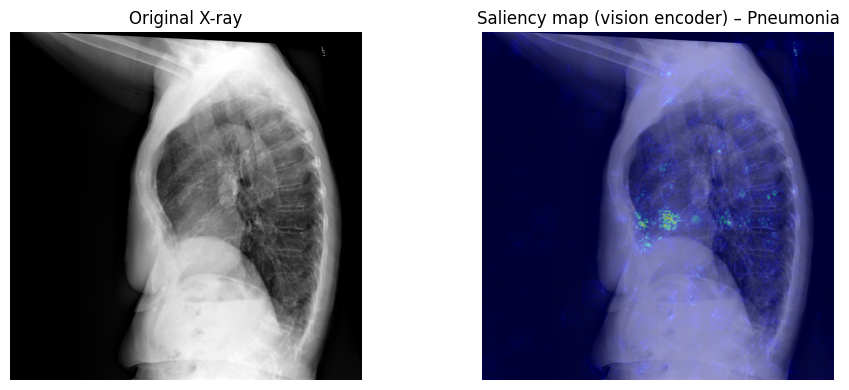

In [37]:
img_path = GLOBAL_DEMO_IMAGE_PATH

# Find its row in df_final (to get labels)
row = df_final[df_final["image_path"] == img_path].iloc[0]
pil_img = Image.open(img_path).convert("RGB")

label_list = row["detected_entities"]
target_label = label_list[0] if len(label_list) > 0 else "Normal"

heat = clip_image_saliency(pil_img, model, preprocess, device)
heat_resized = cv2.resize(heat, (pil_img.size[0], pil_img.size[1]))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(pil_img, cmap="gray")
plt.title("Original X-ray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(pil_img, cmap="gray")
plt.imshow(heat_resized, cmap="jet", alpha=0.4)
plt.title(f"Saliency map (vision encoder) – {target_label}")
plt.axis("off")

plt.tight_layout()
plt.show()

In [38]:
with open("smart_adapter.pkl", "wb") as f:
    pickle.dump(clf, f)
with open("multilabel_binarizer.pkl", "wb") as f:
    pickle.dump(mlb, f)
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)


# Feature scaler (StandardScaler) – critical for the classifier
if 'scaler' in globals():
    with open("scaler.pkl", "wb") as f:
        pickle.dump(scaler, f)
else:
    print("Warning: Scaler not found! Make sure you ran Cell 42.")

print("All models saved successfully! (Ready for deployment)")

All models saved successfully! (Ready for deployment)


In [39]:
# FINAL DATABASE REPAIR (Syncs with Streamlit & New Logic)
import pandas as pd
import pickle
import os
import re

print("Repairing dataset with PRO Entity Map...")

# 1. Load the current dataset
filename = "dataset_final_fixed.pkl" 
if not os.path.exists(filename):
    filename = "dataset_with_embeddings_fixed.pkl"

if os.path.exists(filename):
    with open(filename, "rb") as f:
        df_repair = pickle.load(f)
    print(f"Loaded {len(df_repair)} rows.")
else:
    print("Error: No dataset file found to repair!")
    
    raise FileNotFoundError("Please generate embeddings first.")

# 2. Final comprehensive dictionary (PRO ENTITY MAP)
# This is the same mapping used for highlighting and the knowledge graph
ENTITY_MAP = {
    # قلب
    # Heart-related concepts
    "cardiomegaly": "Cardiomegaly", 
    "enlarged heart": "Cardiomegaly", 
    "heart enlargement": "Cardiomegaly", 
    "cardiac enlargement": "Cardiomegaly", 
    "prominent cardiac silhouette": "Cardiomegaly", 
    "ctr > 0.5": "Cardiomegaly",
    
    # ذات‌الریه و عفونت
    # Pneumonia and infectious patterns
    "pneumonia": "Pneumonia", 
    "infection": "Pneumonia", 
    "consolidation": "Pneumonia", 
    "airspace disease": "Pneumonia", 
    "infiltration": "Pneumonia", 
    "opacities": "Pneumonia", 
    "hazy opacity": "Pneumonia",
    
    # آتلتکتازی
    # Atelectasis-related patterns
    "atelectasis": "Atelectasis", 
    "collapse": "Atelectasis", 
    "volume loss": "Atelectasis", 
    "plate-like opacity": "Atelectasis",
    
    # ادم ریوی
    # Pulmonary edema and congestion
    "edema": "Edema", 
    "fluid overload": "Edema", 
    "congestion": "Edema", 
    "pulmonary edema": "Edema", 
    "vascular congestion": "Edema", 
    "kerley b lines": "Edema", 
    "peribronchial cuffing": "Edema",
    
    # پلورال افیوژن
    # Pleural effusion
    "pleural effusion": "PleuralEffusion", 
    "effusion": "PleuralEffusion", 
    "fluid in chest": "PleuralEffusion", 
    "blunting of costophrenic": "PleuralEffusion", 
    "meniscus sign": "PleuralEffusion",
    
    # پنوموتوراکس
    # Pneumothorax
    "pneumothorax": "Pneumothorax", 
    "air in chest": "Pneumothorax", 
    "pleural line": "Pneumothorax", 
    "lucency": "Pneumothorax",
    
    # شکستگی
    # Fracture-related findings
    "fracture": "Fracture", 
    "broken": "Fracture", 
    "deformity": "Fracture", 
    "osseous discontinuity": "Fracture", 
    "callus": "Fracture", 
    "rib fracture": "Fracture",
    
    # نرمال
    # Normal / no acute disease
    "normal": "Normal", 
    "no acute": "Normal", 
    "clear": "Normal", 
    "unremarkable": "Normal", 
    "intact": "Normal", 
    "stable": "Normal", 
    "within normal limits": "Normal", 
    "grossly normal": "Normal"
}

def extract_medical_entities_repair(text):
    if not isinstance(text, str): return ["Normal"]
    text = text.lower()


    # Text normalization to avoid concatenated words
    # Remove de-identification tags
    # Keep only letters, digits, spaces and periods
    # Collapse multiple spaces
    text = text.lower()
    text = re.sub(r'xxxx', ' ', text)
    text = re.sub(r'[^a-z0-9\s\.]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text_padded = f" {text} " 
    
    found_entities = set()
    
    for keyword, standardized in ENTITY_MAP.items():
        if f" {keyword} " in text_padded or keyword in text:
            found_entities.add(standardized)
            
    # Conflict Resolution
    if len(found_entities) > 1 and "Normal" in found_entities:
        found_entities.discard("Normal")
        
    if not found_entities:
        found_entities.add("Normal")
        
    return list(found_entities)

# 3. Re-apply label extraction using the updated logic
print("Re-extracting labels with updated logic...")

# Choose the source column for the text
source_col = 'caption'
if source_col not in df_repair.columns:
    print("'caption' column missing! Reconstructing from findings/impression...")
    df_repair['caption'] = (df_repair['findings'].fillna('') + " " + df_repair['impression'].fillna('')).str.strip()

# Run
df_repair['detected_entities'] = df_repair['caption'].apply(extract_medical_entities_repair)

# 4. Save back (overwrite both filenames for compatibility with Streamlit)
# We write to both filenames so that the Streamlit app can find the correct file
with open("dataset_final_fixed.pkl", "wb") as f:
    pickle.dump(df_repair, f)

with open("dataset_with_embeddings.pkl", "wb") as f:
    pickle.dump(df_repair, f)

print(f"Sample Check (Row 0): {df_repair['detected_entities'].iloc[0]}")

Repairing dataset with PRO Entity Map...
Loaded 7426 rows.
Re-extracting labels with updated logic...
Sample Check (Row 0): ['Pneumonia', 'PleuralEffusion', 'Edema', 'Pneumothorax']
